For reference use examples provided by Kwakkel (2018): https://github.com/quaquel/pyNetLogo/blob/55431ddb3c75c5dec41855fca874fbc7e9034ce1/examples/SALib_sequential.ipynb
Make sure when implementing the code, that the file directories where the model is stored is correct.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyNetLogo

#Import the sampling and analysis modules for a Sobol variance-based sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol

In [5]:
problem = { 
  'num_vars': 6,
  'names': ['MW-block-res',
            'MW-block-price-res',
            'fac-spend-rpv',
            'electricity-price',
            'kWh-kW',
            'discount-rate'], 
  'bounds': [[100, 200],
             [100, 300],
             [2 , 6],
             [0.15 , 0.3],
             [800 , 1100],
             [0.025 , 0.075]
            ]
}


In [3]:
import os

netlogo = pyNetLogo.NetLogoLink(gui=False)
model_file = os.path.join(netlogo.netlogo_home, 'models/Model 01-02.1 final.nlogo')
netlogo.load_model(model_file)

In [4]:
n = 100
param_values = saltelli.sample(problem, n, calc_second_order=True)

/Users/flipsteenbrink/opt/anaconda3/lib/python3.7/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (100) is equal to `2^n`.
        
  warnings.warn(msg)


In [5]:
param_values.shape

(1400, 6)

In [6]:
results = pd.DataFrame(columns=['Avg finances'])
results

,Avg finances


In [7]:
import time

t0 = time.time()

for run in range(param_values.shape[0]):
    
    #Set the input parameters
    for i, name in enumerate(problem['names']):
        if name == 'random-seed':
            #The NetLogo random seed requires a different syntax
            netlogo.command('random-seed {}'.format(param_values[run,i]))
        else:
            #Otherwise, assume the input parameters are global variables
            netlogo.command('set {0} {1}'.format(name, param_values[run,i]))
            
    netlogo.command('setup')
    #Run for 100 ticks and return the number of sheep and wolf agents at each time step
    counts = netlogo.repeat_report(['count households with [switched-pv = true]'], 520, include_t0=False)
    
    #For each run, save the mean value of the agent counts over time]
    results.loc[run, 'Avg finances'] = counts['count households with [switched-pv = true]'].values.mean()
    
elapsed = time.time()-t0 #Elapsed runtime in seconds

In [8]:
results

,Avg finances
0,136.435
1,138.437
2,125.988
3,144.535
4,123.39
...,...
1395,137.212
1396,131.075
1397,119.031
1398,142.233


In [17]:
results.to_csv('Sobol_sequential_hh_finances.csv')

In [3]:
results = pd.read_csv('Sobol_sequential_hh_finances.csv', header=0, index_col=0)

In [19]:
elapsed

23693.80118894577

In [6]:
Si = sobol.analyze(problem, results['Avg finances'].values, calc_second_order=True, print_to_console=False)

In [7]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

In [8]:
Si_df

,ST,ST_conf,S1,S1_conf
MW-block-res,0.919871,0.297655,-0.008958,0.239536
MW-block-price-res,0.997258,0.273487,-0.135204,0.292929
fac-spend-rpv,0.808814,0.218334,0.260151,0.265950
electricity-price,0.872655,0.253493,-0.029634,0.230455
kWh-kW,0.896745,0.218359,0.052626,0.316172
discount-rate,0.993209,0.314313,0.072695,0.278197


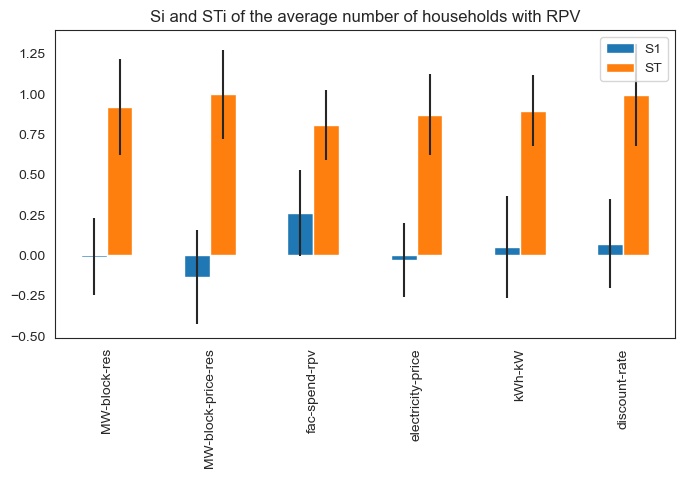

In [10]:
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
ax.set_title('Si and STi of the average number of households with RPV')
fig.set_size_inches(8,4)

plt.savefig('Si and STi of the average number of households with RPV', bbox_inches='tight')


plt.show()